### 04 Verify the accuracy of RKP simulation with experimental ECP results
This notebook demonstrates the process for confirming the accuracy of RKP simulation of a given grain from the polycrystal steel sample by comparing with experimental ECP. Stage position auto-correlation is also verified by comparing with experimental SEM/ECCI image. 

#### Load dependent packages

In [1]:
import os
import numpy as  np
import matplotlib.pyplot as plt
from pathlib import Path
import kikuchipy as kp
from orix.quaternion import Rotation
from openECCI import io, optimization, rkp, stagecomputation

#### Load orientation calibration related files from Si[001] wafer
- Si[001] reference ECP pattern
- EBSD master pattern of Si at corresponding electron beam energy
- EBSD map file (.ctf is used) from the Si[001] wafer

__Note__: It is critical to take a new reference ECP pattern from the Si[001] wafer every time after the sample is loaded in SEM, so as to minimize the small deviations in sample mounting orientation. 

In [3]:
# Path to Si ECP reference pattern
si_ref_ecp_path = Path("../openECCI-data/fcc_fe/")
si_ref_ecp_file = "01_Si_ref.tif"
si_ref_ecp_fname = os.path.join(si_ref_ecp_path, si_ref_ecp_file)
ref_ecp = plt.imread(si_ref_ecp_fname)

# Path to Si master pattern @ 20kV generated by EMsoft
si_MP_path = Path("../openECCI-data/ebsd_master_pattern/")
si_MP_file = "Si-master-20kv.h5"
si_MP_fname = os.path.join(si_MP_path, si_MP_file)
# si_MP = kp.load(si_MP_fname, projection="lambert", hemisphere="both", energy=20)
si_ECP_MP = kp.load(si_MP_fname, projection="lambert", hemisphere="both", energy=20)

# Path to Si .ctf file containing the EBSD euler angles
si_xmap_path = Path("../openECCI-data/ebsd_map/")
si_xmap_file = "20kv_26nA_15mm WD_4x4 binning Si Map.ctf"
si_xmap_fname = os.path.join(si_xmap_path, si_xmap_file)

#### Apply orientation calibration 
This is an identical but simplified process that has been demonstrated in tutorial notebook [01_orientation_calibration](./01_orientation_calibration.ipynb).

In [4]:
guess_coefficients = [0.1, 0.5, 0, 4]

si_average_rotation = io.get_avg_orientation(si_xmap_fname)

a = optimization.orientation_calibration(corr_angles=[guess_coefficients[0], guess_coefficients[1], guess_coefficients[2]],
                            PCz=guess_coefficients[3],
                            reference_ECP_path=si_ref_ecp_fname,
                            si_master_pattern=si_ECP_MP,
                            Si_xtal=si_average_rotation)

optimized_correction_coefficients = a.optimize_calibration(method="NDP")

Orientation Calibration Object created using the following parameters:               
Initial guess corrections: {'tiltX_corr_angle': 0.1, 'tiltY_corr_angle': 0.5, 'tiltZ_corr_angle': 0, 'PCz': 4},              
Reference ECP: ..\openECCI-data\fcc_fe\01_Si_ref.tif,              
Master Pattern: <EBSDMasterPattern, title: , dimensions: (2|1001, 1001)>
Optimization terminated successfully.
         Current function value: 0.035442
         Iterations: 165
         Function evaluations: 317
Rotation calibration optimized using NDP method
tiltX_corr_angle: -0.5312103261068537, tiltY_corr_angle: 1.2285403872457656, tiltZ_corr_angle: 0.06380671840706255 PCz: 3.890243796249578
NDP: 0.9645581053982366


#### Load files that are relevant to the polycrystal sample
- EBSD master pattern of austenitic stainless steel at corresponding electron beam energy (20kV).
- EBSD map file (.ctf is used) from the steel sample.
- An overview SEM image from the EBSD mapping area.

In [5]:
# Path to fcc_Fe master pattern generated by EMsoft
fe_MP_path = Path("../openECCI-data/ebsd_master_pattern/")
fe_MP_file = "Fe-master-20kV.h5"
fe_MP_fname = os.path.join(fe_MP_path, fe_MP_file)
fe_MP = kp.load(fe_MP_fname, projection="lambert", hemisphere="both", energy=20)

# Path to fcc_Fe .ctf file containing the EBSD euler angles
fe_xmap_path = Path("../openECCI-data/ebsd_map/")
fe_xmap_file = "20kv_26nA_15mm WD_4x4 bin_fcc_Fe Map.ctf"
fe_xmap_fname = os.path.join(fe_xmap_path, fe_xmap_file)
fe_xmap = io.load_xmap(fe_xmap_fname)

# Reference overview image 
sem_path = Path("../openECCI-data/fcc_fe")
sem_file = "01_steel overview.tif"
sem_fname = os.path.join(sem_path, sem_file)

#### Apply image correlation between EBSD IPF map and SEM overview image
This is an identical but simplified process that has been demonstrated in tutorial notebook [03_polycrystal_SEM_IPF_correlation](./03_polycrystal_SEM_IPF_correlation.ipynb).

In [6]:
correlation = optimization.ipf_image_correlation(sem_fname, fe_xmap_fname)
ipf_map = correlation.get_ipf_map(phase_name="Iron fcc", plot=False)
correlation.load_alignment_points(load_path="alignment_points.pkl")
ipf_warp_blended, _ = correlation.process(plot=False)

Phase     Orientations         Name  Space group  Point group  Proper point group     Color
   -1      8358 (2.5%)  not_indexed         None         None                None         w
    1   322978 (97.5%)     Iron fcc        Fm-3m         m-3m                 432  tab:blue
Properties: bands, error, MAD, BC, BS
Scan unit: um
24 alignment points have been loaded.


#### Load experiment ECP together with the SEM/ECCI image from the location ECP was acquired
The SEM/ECCI image is a BSE image from the location of ECP acquisition. It helps to verify the automated stage position correlation function, however, it is not a mandatory process.
- `fe_exp_ecp` is the ECP pattern from a grain of the steel sample
- `fe_ecci_SEM` is a BSE image of the crystal grain where ECP was acquired at slightly higher magnification. 

In [8]:
fe_ecp_path = Path("../openECCI-data/fcc_fe/")
fe_ecp_file = "steel_ECP_001.tif"
fe_ecp_fname = os.path.join(fe_ecp_path, fe_ecp_file)
fe_exp_ecp = plt.imread(fe_ecp_fname)

fe_ecci_path = Path("../openECCI-data/fcc_fe/")
fe_ecci_file = "steel_SEM_001.tif"
fe_ecci_fname = os.path.join(fe_ecci_path, fe_ecci_file)
fe_ecci_sem = plt.imread(fe_ecci_fname)

#### Compute the pixel position of ECP acquisition location within the overview SEM image
Stage position difference between two images can be retrieved from the images' metadata by using `stagecomputation.get_relative_stage_pos` function. Note that the reference frame of SEM image and that of SEM stage are not identical. In the SEM image reference frame, the origin point is located at top left corner of the image with _positive-x_ pointing right and _positive-y_ pointing downwards. Therefore, the x-axes for SEM image and SEM stage are pointing towards opposite directions, while the y-axes are pointing the same direction. The difference in sign need to be addressed accordingly for marking the ECP position in the SEM image.


In [9]:
# compute the difference in stage position between the SEM and the ECP in meter
sem_pixel_size = io.get_sem_metadata(sem_fname)["pixel_size"]
sem_resolution = io.get_sem_metadata(sem_fname)["resolution"]
_ , _ , diff_x, diff_y, _ = stagecomputation.get_relative_stage_pos(sem_fname, fe_ecp_fname)

# compute the pixel difference in stage position between the SEM and the ECP in pixels (overview SEM image)
diff_pix_x = diff_x / sem_pixel_size
diff_pix_y = diff_y / sem_pixel_size

# Pixel coordinate of ECP (or high mag image) in the low mag overview SEM image
pos_x = sem_resolution[0]//2 + diff_pix_x
pos_y = sem_resolution[1]//2 - diff_pix_y

#### Preview and validate the calculated ECP acquisition location in overview SEM image
Run this cell to preview the calculated ECP acquisition location in overview SEM image in an interactive blended EBSD map. Depending on the accuracy of the recorded SEM stage coordinate in image metadata, there may exist some positioning errors, especially for very fine grains. To correct the deviation in positioning, double-click at the accurate position to reposition the cross mark.

In [10]:
%matplotlib qt
coord_results = correlation.interactive_blended_xmap(initial_coord=[pos_x, pos_y])

Euler angles at the image point: [146.9424, 43.4434, 8.305199999999997]
Phase name at the image point: <name: Iron fcc. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>


Phase name at the image point: <name: Iron fcc. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>
Euler angles at the image point: [146.9646, 43.50319999999999, 8.274799999999992]


#### Summarize the stage position information and RKP simulation
By using the coordinate output from last cell, the RKP simulation can be compared and validated from different grains in the polycrystal sample. The auto-correlated ECP beam position and the actual stage position are also compared and summarize in the output plot.

stage rotation: 0.0, stage tilt: 0.0


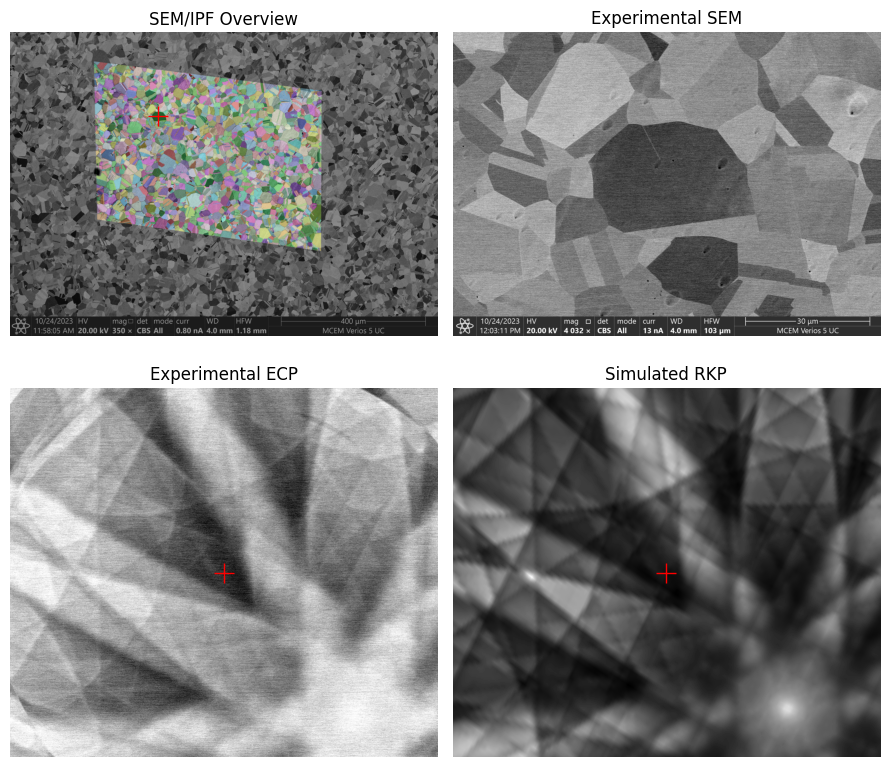

In [11]:
%matplotlib inline
sem_coord = coord_results[0][-1]
euler3 = coord_results[2][-1]
sem_coord, euler3

tiltX_corr_angle_op = optimized_correction_coefficients["tiltX_corr_angle"] # positive direction => pattern moves DOWN
tiltY_corr_angle_op = optimized_correction_coefficients["tiltY_corr_angle"] # positive direction => pattern moves LEFT
tiltZ_corr_angle_op = optimized_correction_coefficients["tiltZ_corr_angle"] # positive direction => pattern rotates COUNTER-CLOCKWISE
PCz_op = optimized_correction_coefficients["PCz"] # Larger value => smaller angular range

# get the stage rotation and tilt relative to the reference ECP
# angles used here are according to the testing reference frame rather than the SEM software rotation and tilt
st_rot_angle, st_tilt_angle, _, _, _  = stagecomputation.get_relative_stage_pos(si_ref_ecp_fname, fe_ecp_fname)

# convert the stage rotation and tilt to Rotation objects
# the negative sign is used because the stage rotation and tilt active rotations. 
# In EBSD, rotations are usually in passive form according to Bunge convention
st_rot = Rotation.from_axes_angles(axes = [0, 0, 1], 
                                   angles = -st_rot_angle, 
                                   degrees = True)
st_tilt = Rotation.from_axes_angles(axes = [0, 1, 0], 
                                    angles = -st_tilt_angle, 
                                    degrees=True)

fe_xtal_rotation = Rotation.from_euler(np.deg2rad(euler3)) * Rotation.from_axes_angles([0, 0, 1], -np.pi / 2)
ecp_resolution = io.get_sem_metadata(fe_ecp_fname)["resolution"]


sim_RKP = rkp.get_sim_rkp(RKP_masterpattern = fe_MP,
                              xtal_rotation = fe_xtal_rotation,
                              st_rot_angle = st_rot_angle,
                              st_tilt_angle = st_tilt_angle,
                              corr_angles=[tiltX_corr_angle_op, tiltY_corr_angle_op, tiltZ_corr_angle_op],
                              ref_ECP=si_ref_ecp_fname,
                              PCz=PCz_op,
                              RKP_shape=ecp_resolution)

fig1, axs = plt.subplots(nrows=2, ncols=2, figsize=(9,8))
axs[0,0].imshow(ipf_warp_blended)
axs[0,0].plot(sem_coord[0], sem_coord[1], 'r+', markersize=14)
axs[0,0].set_title("SEM/IPF Overview")
axs[0,0].axis("off")

axs[0,1].imshow(fe_ecci_sem, cmap="gray")
axs[0,1].set_title("Experimental SEM")
axs[0,1].axis("off")

axs[1,0].imshow(fe_exp_ecp[:ecp_resolution[1],:], cmap='gray')
axs[1,0].plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
axs[1,0].set_title("Experimental ECP")
axs[1,0].axis("off")

axs[1,1].imshow(np.squeeze(sim_RKP.data), cmap='gray')
axs[1,1].plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
axs[1,1].set_title("Simulated RKP")
axs[1,1].axis("off")

plt.tight_layout()
print(f"stage rotation: {np.round(st_rot_angle, 2)}, stage tilt: {np.round(st_tilt_angle, 2)}") 